## Prompt Chain Pattern

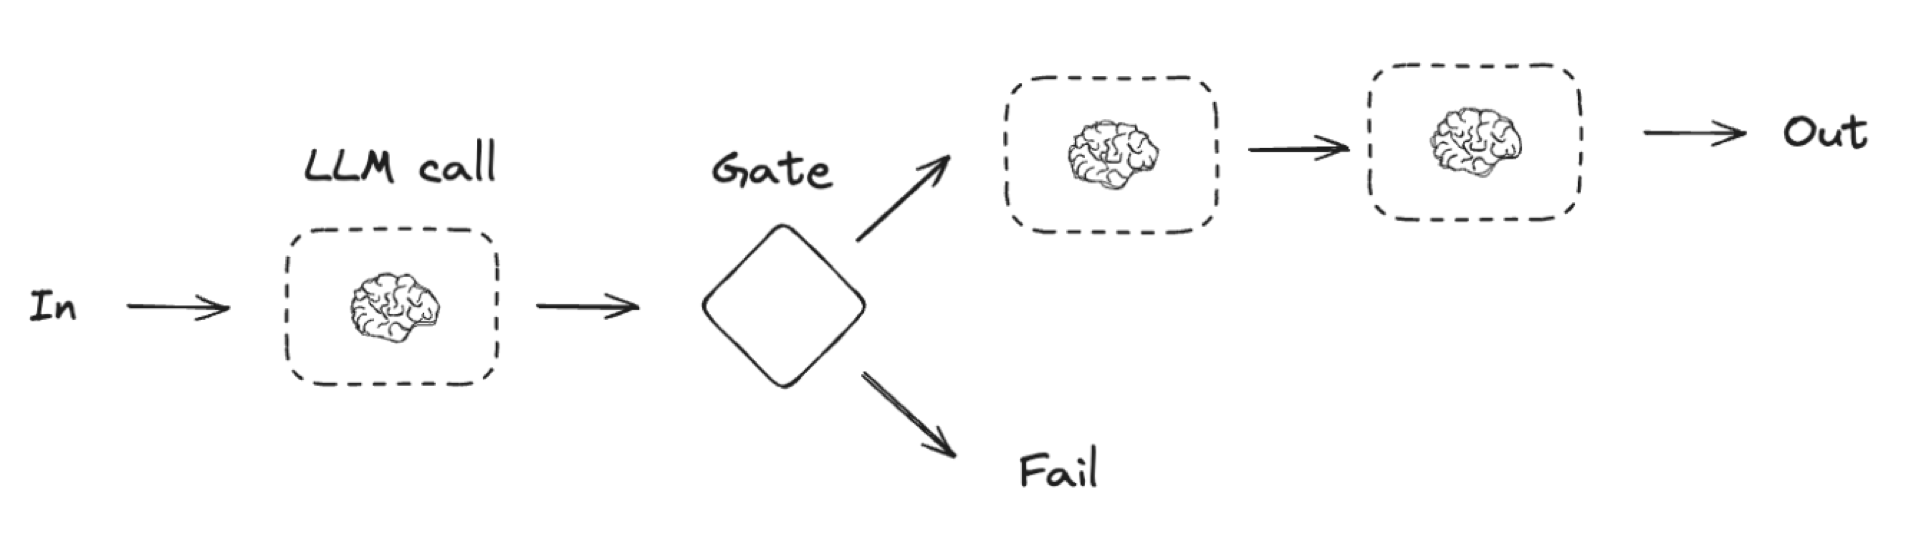

##### Load the environment variables

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()
tavily_api_key = os.getenv('TAVILY_API_KEY')
model_id = os.getenv('MODEL_ID')
aws_region = os.getenv('AWS_REGION')
bedrock_kb_id = os.getenv('BEDROCK_KB_ID')

##### Model

In [2]:
## Model - Agent Brain
from langchain_aws import ChatBedrock
llm = ChatBedrock(model=model_id)

##### State - The schema of the State will be the input schema to all Nodes and Edges in the graph

In [3]:
## Graph State
from typing import TypedDict

class State(TypedDict):
    query: str
    web_search: str
    kb_search: str
    final_blog: str

##### Tools [Tool 1 - Web Search Tool]

In [4]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults

def search_web(state: State):
    print("SEARHING WEB")
    search_tool = TavilySearchResults(max_results=2)
    web_results = search_tool.invoke(state["query"])
    return {"web_search": web_results}

##### Tools [Tool 2 - Bedrock Knowledge Base]

In [ ]:
import boto3
def query_knowledge_base(state: State):
    """Query the knowledge base for information related to Agents and Agentic workflow
    
    Args:
        query: The query string to search for
    """
    bedrock_agent = boto3.client('bedrock-agent-runtime', region_name = 'us-east-1')
    print("QUERYING KB")


    response = bedrock_agent.retrieve_and_generate(
        input={
            "text": state["query"]  # Your query text goes here
        },
        retrieveAndGenerateConfiguration={
            "type": "KNOWLEDGE_BASE",
            "knowledgeBaseConfiguration": {
                "knowledgeBaseId": bedrock_kb_id,
                "modelArn": model_id,
                "retrievalConfiguration": {
                    "vectorSearchConfiguration": {
                        "numberOfResults": 5
                    }
                }
            }
        }
    )

    kb_results = response['output']['text']
    return {"kb_search" : kb_results}

##### Tools [Tool 3 - Blog writer tool]

In [6]:
def blogger(state: State):
    print("WRITING KB")
    prompt = f""" Your job is to create a blog title and a one paragraph blog from this content: {state['kb_search']}"""
    final_answer = llm.invoke(prompt)           
    return {"final_blog": final_answer.content}   

##### Build the Graph

In [7]:
from langgraph.graph import StateGraph, START, END

# Build workflow
chainer = StateGraph(State)

# Add nodes
chainer.add_node("search_kb", query_knowledge_base)
chainer.add_node("blog_writer", blogger)

# Add edges to connect nodes
chainer.add_edge(START, "search_kb")
chainer.add_edge("search_kb", "blog_writer")
chainer.add_edge("blog_writer", END)

##### Compile the graph

In [8]:
agent = chainer.compile()

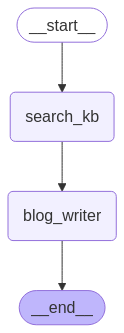

In [9]:

from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

##### Run the agent

In [13]:
state = agent.invoke({"query": "Who is usain bolt"})
state['final_blog']


QUERYING KB
WRITING KB


'Blog Title: "When AI Says No: Understanding Digital Boundaries and Ethical Limits"\n\nBlog Paragraph:\nIn an era where artificial intelligence is becoming increasingly prevalent in our daily lives, it\'s fascinating to encounter moments when AI systems explicitly decline to assist with certain requests. The simple response "Sorry, I am unable to assist you with this request" represents more than just a programmed limitation – it reflects the careful ethical boundaries and safeguards built into modern AI systems. These boundaries exist to protect users, maintain ethical standards, and ensure responsible AI deployment. While it might be frustrating to receive such a response, it\'s actually a reassuring sign that AI systems are designed with clear parameters and are programmed to recognize when requests fall outside their scope of capability or ethical framework.'

#### Conditional Edges

##### Define Conditional Node

In [7]:
def conditional_node(state:State):
    condition = "I apologize"
    if condition in state['kb_search']:
        return "fail"
    else:
        return "pass"

##### Build the graph

In [ ]:
from langgraph.graph import StateGraph, START, END

# Build workflow
chainer = StateGraph(State)

# Add nodes
chainer.add_node("search_kb", query_knowledge_base)
chainer.add_node("search_web", search_web)
chainer.add_node("blog_writer", blogger)

# Add edges to connect nodes
chainer.add_edge(START, "search_kb")
chainer.add_conditional_edges("search_kb", conditional_node, {"pass": "blog_writer", "fail" : "search_web"})
chainer.add_edge("search_web", "blog_writer")
chainer.add_edge("blog_writer", END)

##### Compile the graph

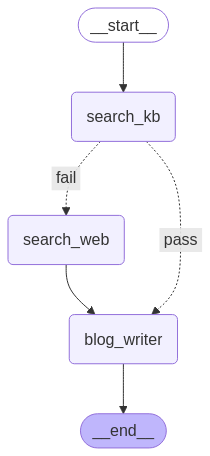

In [15]:
agent = chainer.compile()

from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

##### Run the Agent

In [16]:
state = agent.invoke({"query": "who is usain bolt"})
state['final_blog']

QUERYING KB
SEARHING WEB
WRITING KB


"Title: The Curious Case of Missing Data: When AI Draws a Blank\n\nIn our increasingly digital world, we often take instant access to information for granted. However, there are fascinating moments when even sophisticated AI systems must acknowledge their limitations and data gaps. This transparency in admitting what isn't known, rather than fabricating information, is actually a crucial feature of reliable AI systems. Just as a librarian might tell you that a particular book isn't in their collection, AI's ability to recognize and communicate its knowledge boundaries represents an important step forward in creating trustworthy artificial intelligence that humans can depend on."